In [1]:
import sqlite3                   # data is stored in a sql table
from sqlite3 import Error
import csv                       # requests through CityOfChicago API can be done json, csv and other formats. I prefer csv.
import requests                  # to get the data from the Chicago site
import pandas as pd              # get a better view of the info in sqlite (sqlite is not very friendly to visualize tables)
from datetime import datetime
import time

import os                        # to manage files in hard drive


In [2]:
#url = 'https://data.cityofchicago.org/resource/m6dm-c72p.json?$$app_token=jgQqhL8MrkDPkmBlNFolO6a13&$where=trip_start_timestamp%20%3E=%20%272021-01-01T00:00:00%27&$limit=1000'
#print(url)
#content = requests.get(url).content
#dataset = json.loads(content)
#print(len(dataset))
#print(dataset[0])

### Create sqlite database and set connection

#### database is created in the same directory of the notebook

In [3]:
connection = sqlite3.connect("chicago_pub.sqlite") #, isolation_level=None) # change to 'sqlite:///your_filename.db'
cur = connection.cursor()

### Create table for the raw data from Chicago site.

#### this table is not needed as the summary table is built with temp data month by month

### create temp table for each month, onces summarized is deleted.

trips_csv stores all the data retrieved from the Chicago site
trips_temp stores only one month of data, that month is summarized and the table is dropped and recreated.

In [4]:
def create_temp():

    
    #connection.execute("DROP TABLE IF EXISTS trips_temp;")
    cur.execute("""CREATE TABLE trips_temp(trip_id TEXT, 
                                          trip_start_timestamp TEXT, 
                                          trip_end_timestamp TEXT, 
                                          trip_seconds REAL, 
                                          trip_miles REAL, 
                                          pickup_census_tract TEXT NULL, 
                                          dropoff_census_tract TEXT NULL, 
                                          pickup_community_area INTEGER, 
                                          dropoff_community_area INTEGER, 
                                          fare REAL, 
                                          tip REAL, 
                                          additional_charges REAL, 
                                          trip_total REAL, 
                                          shared_trip_authorized TEXT, 
                                          trips_pooled REAL,
                                          pickup_centroid_latitude TEXT, 
                                          pickup_centroid_longitude TEXT, 
                                          pickup_centroid_location TEXT, 
                                          dropoff_centroid_latitude TEXT, 
                                          dropoff_centroid_longitude TEXT, 
                                          dropoff_centroid_location TEXT);
                """) 
    
    return 

## Create summary table table at first iteration of request:

- trip startdate (yyyy-mm-dd)
- year (2018...)
- month (1..12),
- week of year (1..55),
- day of year (1..366),
- day of week (Sunday, Monday.....)
- hour of day (0..23)
- pickup community area
- pickup centroid location
- COUNT of trips
- SUM of trip seconds
- SUM of trip miles
- Sum of fare
- Sum of tip
- Sum of additional charges
- Sum of total 



In [5]:

def create_summary():

    start = datetime.now()
#    print("start_query =", start)


    connection.execute("DROP TABLE IF EXISTS trips_summary;")

    

    sql = """CREATE TABLE trips_summary AS
                SELECT strftime('%Y-%m-%d',trip_start_timestamp) as date,
                    CAST(strftime('%Y',trip_start_timestamp) AS INTEGER) as year,
                    CAST(strftime('%m',trip_start_timestamp) AS INTEGER) as month,
                    CAST(strftime('%W',trip_start_timestamp) AS INTEGER) as week_year,
                    CAST(strftime('%j',trip_start_timestamp) AS INTEGER) as day_year,
                    case cast (strftime('%w', trip_start_timestamp) as integer)
                      when 0 then 'Sunday'
                      when 1 then 'Monday'
                      when 2 then 'Tuesday'
                      when 3 then 'Wednesday'
                      when 4 then 'Thursday'
                      when 5 then 'Friday'
                      else 'Saturday' end as week_day,
                    CAST(strftime('%H',trip_start_timestamp) AS INTEGER) as hour,
                    pickup_community_area,
                    count(*) as count,
                    sum(trip_seconds) as trip_seconds_tot,
                    sum(trip_miles) as trip_miles_tot,
                    sum(fare) as fare_tot, 
                    sum(tip) as tip_tot, 
                    sum(additional_charges) additional_tot, 
                    sum(trip_total) trip_total_tot,
                    sum(fare+tip) as total_revenue                
                FROM trips_temp
                WHERE fare > 0
                      AND pickup_community_area <> ''
                      AND trip_total > 0
                GROUP BY 1,2,3,4,5,6,7,8;"""
    cursor = connection.execute(sql)

    connection.commit()

    end = datetime.now()
 #   print("end_query =", end)

    return print("time_create_summary =", end - start)

### Inserts into summary at subsequent interations

In [6]:

def insert_summary():

    start = datetime.now()
#    print("start_query =", start)



    sql = """INSERT INTO trips_summary 
                SELECT strftime('%Y-%m-%d',trip_start_timestamp) as date,
                    CAST(strftime('%Y',trip_start_timestamp) AS INTEGER) as year,
                    CAST(strftime('%m',trip_start_timestamp) AS INTEGER) as month,
                    CAST(strftime('%W',trip_start_timestamp) AS INTEGER) as week_year,
                    CAST(strftime('%j',trip_start_timestamp) AS INTEGER) as day_year,
                    case cast (strftime('%w', trip_start_timestamp) as integer)
                      when 0 then 'Sunday'
                      when 1 then 'Monday'
                      when 2 then 'Tuesday'
                      when 3 then 'Wednesday'
                      when 4 then 'Thursday'
                      when 5 then 'Friday'
                      else 'Saturday' end as week_day,
                    CAST(strftime('%H',trip_start_timestamp) AS INTEGER) as hour,
                    pickup_community_area,
                    count(*) as count,
                    sum(trip_seconds) as trip_seconds_tot,
                    sum(trip_miles) as trip_miles_tot,
                    sum(fare) as fare_tot, 
                    sum(tip) as tip_tot, 
                    sum(additional_charges) additional_tot, 
                    sum(trip_total) trip_total_tot,
                    sum(fare+tip) as total_revenue                
                FROM trips_temp
                WHERE fare > 0
                      AND pickup_community_area <> ''
                      AND trip_total > 0
                GROUP BY 1,2,3,4,5,6,7,8;"""
    cursor = connection.execute(sql)

    connection.commit()

    end = datetime.now()
#    print("end_query =", end)

    return print("time_insert_summary =", end - start)

### Retrieve data from Chicago Site in CSV format using SOCRATA API

https://github.com/pankhurikumar23/socrataAPI

#### Insert into Trips Sqlite and call create/insert for summary table

the info is retrieved, stored and summarized month by month

Trying to get all the info at once saturates RAM and makes the PC unresponsive and unusable.


In [7]:



main = 'https://data.cityofchicago.org/resource/m6dm-c72p.csv?'

token = '$$app_token=TEOwHbkd1vVtNleSBB7y8V7GA'

#yer
condition_a = '&$where=date_extract_y(trip_start_timestamp)='

#month
condition_b = '%20and%20date_extract_m(trip_start_timestamp)='

limit = '&$limit=100000000'

inicio = datetime.now()

print("inicio_todo =", inicio)


#The following loop iterates over years and months to build a url request for each month at a time 
#and then insert the data into a SQLite table.
#Trying to get all the info at once saturates RAM and makes the PC unresponsive and unusable.

#adjust years and months below for the perior required

years = [2018,2019,2020,2021]
months = range(1,13)

#for the first iteration creates summary table, for subsequent inserts into summary table

iteracion = 0

for y in years:
    for m in months:
        
        # this if avoid querying months that do not exist in the Site (before Nov 19 and after Jan 21, 
        #each query for a month that does not hava data can take more than 5 minutes        
        
        if (y == 2018 and m < 11) or (y == 2021 and m > 1):
            continue

        # request to the site using the complete url
        
        url_csv = main + token + condition_a + str(y) + condition_b + str(m) + limit

        start = datetime.now()

        print("start_request =", y, m,start)

        file_csv = requests.get(url_csv).text

        end = datetime.now()

        print("time_request", y,m, end - start)

        # split retrieved info into rows at each "\n"

        start = datetime.now()

        lines = file_csv.splitlines()

        # convert the info to CSV

        reader = csv.reader(lines)
        #skip header line
        next(reader)


        end = datetime.now()

        print("time_csv", y,m, end - start)

        start = datetime.now()

        #insert values into trips_csv
        
#        cur.executemany("INSERT INTO trips_csv VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)", reader)         
#        connection.commit()
        
#        reader = csv.reader(lines)
 #       next(reader)
        
        #insert values into trips_temp
        create_temp()
        cur.executemany("INSERT INTO trips_temp VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)", reader)         
        connection.commit()
        
        sql = "SELECT count(*) FROM trips_temp;"
        cursor = connection.execute(sql)
        print("trips_temp: ", cursor.fetchall())
        
        end = datetime.now()

        print("time_insert", y,m, end - start)

        del reader
             
        cur.execute(""" SELECT count(name) FROM sqlite_master WHERE type='table' AND name='trips_summary' """)

        #if the count is 1, then table exists
        if cur.fetchone()[0]==1 : 
            insert_summary()
        else :
            print('Summary table does not exist.')
            create_summary()
        
        #drop table temp to create a new temp for the next month (for-loop iteration)
        
        cur.execute(""" DROP TABLE trips_temp;""")
        connection.commit()
                
fin = datetime.now()

# prints total time for the process

print("tiempo_todo =", fin - inicio)




inicio_todo = 2021-04-02 07:15:34.510364
start_request = 2018 11 2021-04-02 07:15:34.514030
time_request 2018 11 0:10:44.225699
time_csv 2018 11 0:00:05.360852
trips_temp:  [(8780411,)]
time_insert 2018 11 0:01:48.258217
Summary table does not exist.
time_create_summary = 0:01:01.456076
start_request = 2018 12 2021-04-02 07:29:53.327902
time_request 2018 12 0:08:33.942298
time_csv 2018 12 0:00:26.779415
trips_temp:  [(8681042,)]
time_insert 2018 12 0:01:32.654314
time_insert_summary = 0:01:40.612037
start_request = 2019 1 2021-04-02 07:43:14.710064
time_request 2019 1 0:08:45.921279
time_csv 2019 1 0:00:28.087165
trips_temp:  [(8784983,)]
time_insert 2019 1 0:01:33.267174
time_insert_summary = 0:01:02.066247
start_request = 2019 2 2021-04-02 07:55:49.490608
time_request 2019 2 0:12:53.407617
time_csv 2019 2 0:00:19.145607
trips_temp:  [(8849315,)]
time_insert 2019 2 0:01:28.869237
time_insert_summary = 0:00:59.468767
start_request = 2019 3 2021-04-02 08:12:13.652385
time_request 2019 3

### view first rows of summary

In [8]:
# view first rows

sql = """SELECT *
            FROM trips_summary
            Limit 10
      ;"""

#cursor = connection.execute(sql)

#print(cursor.fetchall())

df_summary_view = pd.read_sql_query(sql, connection)
df_summary_view

,date,year,month,week_year,day_year,week_day,hour,pickup_community_area,count,trip_seconds_tot,trip_miles_tot,fare_tot,tip_tot,additional_tot,trip_total_tot,total_revenue
0,2018-11-01,2018,11,44,305,Thursday,0,1,74,58767.0,398.706782,715.0,44.0,166.70,925.70,759.0
1,2018-11-01,2018,11,44,305,Thursday,0,2,33,22450.0,126.391116,230.0,4.0,80.21,314.21,234.0
2,2018-11-01,2018,11,44,305,Thursday,0,3,219,173141.0,1109.903238,2102.5,131.0,525.87,2759.37,2233.5
3,2018-11-01,2018,11,44,305,Thursday,0,4,61,50194.0,308.281846,550.0,28.0,142.50,720.50,578.0
4,2018-11-01,2018,11,44,305,Thursday,0,5,87,61894.0,311.618548,655.0,42.0,191.27,888.27,697.0
5,2018-11-01,2018,11,44,305,Thursday,0,6,795,603114.0,3291.116724,6460.0,249.0,1803.82,8512.82,6709.0
6,2018-11-01,2018,11,44,305,Thursday,0,7,500,405165.0,2379.158014,4567.5,162.0,1153.06,5882.56,4729.5
7,2018-11-01,2018,11,44,305,Thursday,0,8,1111,838561.0,5467.693400,9857.5,306.0,2609.41,12772.91,10163.5
8,2018-11-01,2018,11,44,305,Thursday,0,9,10,5274.0,30.222446,67.5,1.0,25.30,93.80,68.5
9,2018-11-01,2018,11,44,305,Thursday,0,10,17,11796.0,102.511850,172.5,4.0,43.45,219.95,176.5


### export summary to CSV

In [9]:
sql = """SELECT *
            FROM trips_summary
      ;"""

cursor = connection.execute(sql)

tabla = cursor.fetchall()

tabla[0:2]

[('2018-11-01',
  2018,
  11,
  44,
  305,
  'Thursday',
  0,
  1,
  74,
  58767.0,
  398.7067818855733,
  715.0,
  44.0,
  166.7,
  925.7,
  759.0),
 ('2018-11-01',
  2018,
  11,
  44,
  305,
  'Thursday',
  0,
  2,
  33,
  22450.0,
  126.39111570613903,
  230.0,
  4.0,
  80.21000000000001,
  314.21,
  234.0)]

In [10]:
#EXPORT TO CSV normal

names = [description[0] for description in cursor.description]


if os.path.exists("trips_summary_sql_pub.csv"):
    os.remove("trips_summary_sql_pub.csv")
    
with open('trips_summary_sql_pub.csv','w') as out:
    csv_out=csv.writer(out)
    csv_out.writerow(names)
    for row in tabla:
        csv_out.writerow(row)    

In [11]:
#EXPORT TO CSV using pandas

if os.path.exists("trips_summary_pandas_pub.csv"):
    os.remove("trips_summary_pandas_pub.csv")

df_summary = pd.read_sql_query(sql, connection)

df_summary.to_csv('trips_summary_pandas_pub.csv',index=False)

### Count of lines in summary table

In [12]:
# count summary_trips

start = datetime.now()
print("start_query =", start)


sql = """SELECT count(*)
            FROM trips_summary
      ;"""
cursor = connection.execute(sql)

end = datetime.now()
print("end_query =", end)

cursor.fetchall()



start_query = 2021-04-02 12:48:52.095689
end_query = 2021-04-02 12:48:52.937662


[(1510900,)]

### basic plots about trips and revenue across the time

In [13]:
sql = """SELECT substr(date,1,7) as month_l, sum(count) as count, sum(total_revenue) as revenue
            FROM trips_summary
            GROUP BY 1
      ;"""

#cursor = connection.execute(sql)

#print(cursor.fetchall())

df_month_trip_revenue = pd.read_sql_query(sql, connection, index_col=None)
df_month_trip_revenue

,month_l,count,revenue
0,2018-11,8156754,90564414.5
1,2018-12,8081580,86984598.0
2,2019-01,8196037,85161516.0
3,2019-02,8217412,88159710.5
4,2019-03,9536327,104421330.5
5,2019-04,8548580,101957966.0
6,2019-05,8997097,115196219.5
7,2019-06,8830256,117303700.0
8,2019-07,8494306,101018333.0
9,2019-08,8740617,104779122.0


<AxesSubplot:xlabel='month_l'>

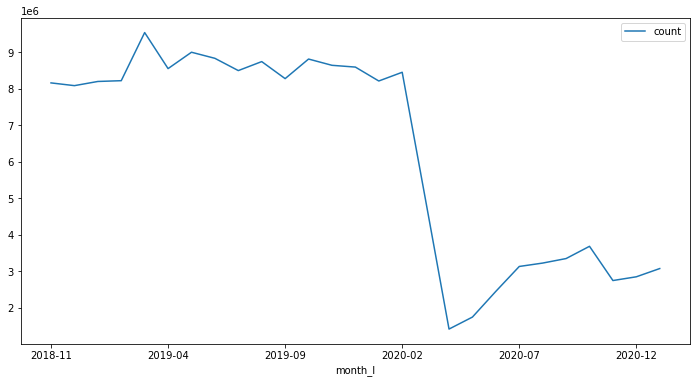

In [14]:
df_month_trip_revenue.plot(x='month_l', y='count', figsize=(12,6))


<AxesSubplot:xlabel='month_l'>

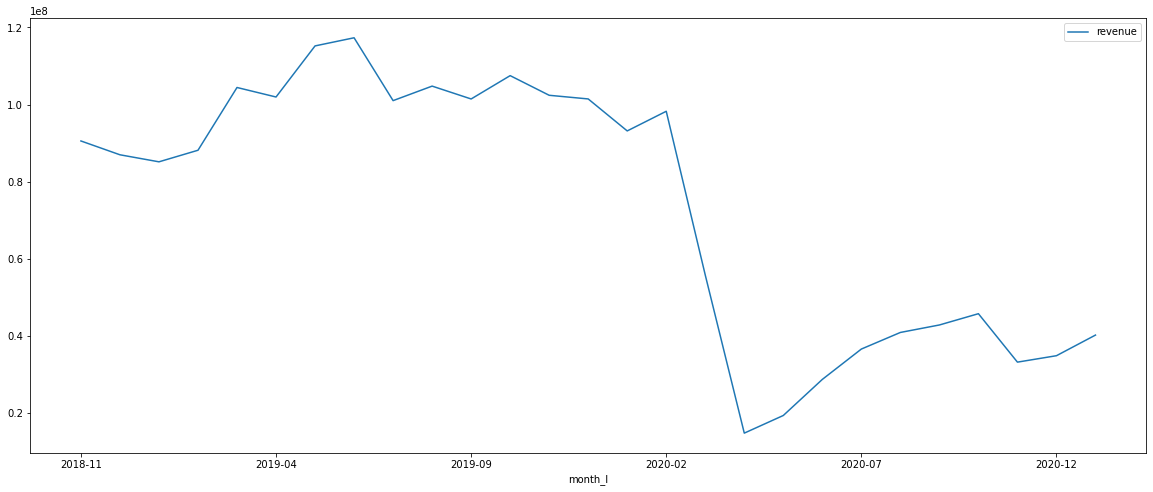

In [15]:
df_month_trip_revenue.plot(x='month_l', y='revenue', figsize=(20,8))

### Number of community areas (pickup)

In [16]:
#COUNT pickup_community_area

sql = """SELECT pickup_community_area, sum(count) as trips
            from trips_summary
            Group by 1
            order by 2 DESC

      ;"""
#cursor = connection.execute(sql)

#cursor.fetchall()

df_comm_area = pd.read_sql_query(sql, connection)
df_comm_area[0:]

,pickup_community_area,trips
0,8,27892354
1,32,14857048
2,28,14824405
3,6,11692002
4,24,10784580
...,...,...
72,74,153915
73,54,149621
74,52,94721
75,47,81531


### basic plot: trips per community area

<AxesSubplot:xlabel='pickup_community_area'>

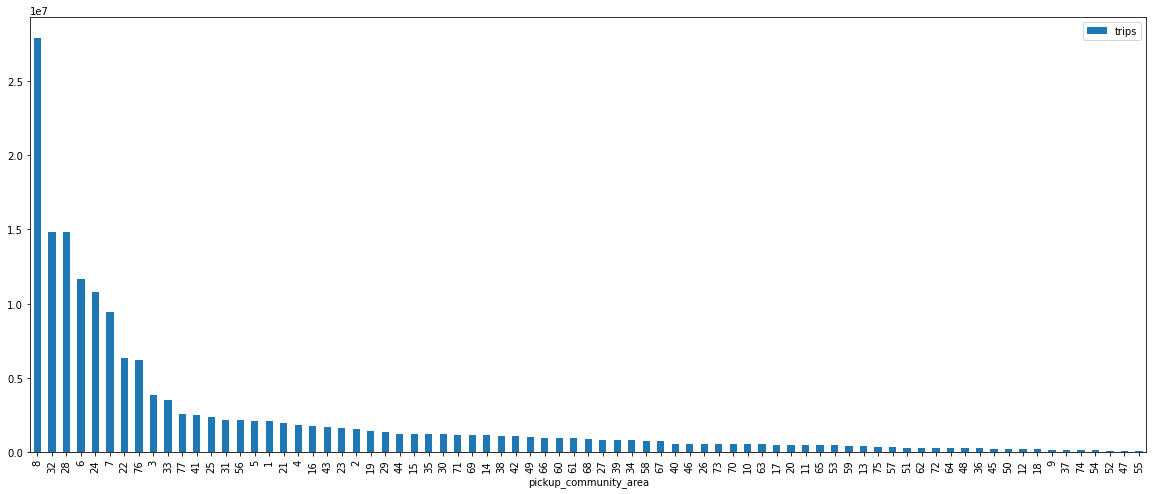

In [17]:
df_comm_area.plot.bar(x='pickup_community_area', y='trips', figsize=(20,8))

In [18]:
#COUNT pickup_community_area

sql = """SELECT date, pickup_community_area, hour, sum(count) as trips, sum(total_revenue) as revenue, sum(total_revenue)/sum(count) as avg_revenue
            from trips_summary
            where year = 2021 and
                  month = 01      
            Group by 1,2,3
      ;"""
#cursor = connection.execute(sql)

#cursor.fetchall()

df_dummy = pd.read_sql_query(sql, connection)
df_dummy

,date,pickup_community_area,hour,trips,revenue,avg_revenue
0,2021-01-01,1,0,80,1078.0,13.475000
1,2021-01-01,1,1,101,2288.0,22.653465
2,2021-01-01,1,2,77,2098.0,27.246753
3,2021-01-01,1,3,81,2115.0,26.111111
4,2021-01-01,1,4,47,977.0,20.787234
...,...,...,...,...,...,...
56753,2021-01-31,77,19,60,803.5,13.391667
56754,2021-01-31,77,20,55,746.0,13.563636
56755,2021-01-31,77,21,51,647.5,12.696078
56756,2021-01-31,77,22,50,716.5,14.330000


In [19]:
df_dummy.to_csv('trips_dummy_january.csv',index=False)

### get the name of the tables that are in the database

In [20]:
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cur.fetchall())

[('trips_csv',), ('trips_summary',)]


### get the schema of the Trips table

In [21]:
#table info

cur.execute("pragma table_info('trips_csv');")
print(cur.fetchall())



[(0, 'trip_id', 'TEXT', 0, None, 0), (1, 'trip_start_timestamp', 'TEXT', 0, None, 0), (2, 'trip_end_timestamp', 'TEXT', 0, None, 0), (3, 'trip_seconds', 'REAL', 0, None, 0), (4, 'trip_miles', 'REAL', 0, None, 0), (5, 'pickup_census_tract', 'TEXT', 0, None, 0), (6, 'dropoff_census_tract', 'TEXT', 0, None, 0), (7, 'pickup_community_area', 'INTEGER', 0, None, 0), (8, 'dropoff_community_area', 'INTEGER', 0, None, 0), (9, 'fare', 'REAL', 0, None, 0), (10, 'tip', 'REAL', 0, None, 0), (11, 'additional_charges', 'REAL', 0, None, 0), (12, 'trip_total', 'REAL', 0, None, 0), (13, 'shared_trip_authorized', 'TEXT', 0, None, 0), (14, 'trips_pooled', 'REAL', 0, None, 0), (15, 'pickup_centroid_latitude', 'TEXT', 0, None, 0), (16, 'pickup_centroid_longitude', 'TEXT', 0, None, 0), (17, 'pickup_centroid_location', 'TEXT', 0, None, 0), (18, 'dropoff_centroid_latitude', 'TEXT', 0, None, 0), (19, 'dropoff_centroid_longitude', 'TEXT', 0, None, 0), (20, 'dropoff_centroid_location', 'TEXT', 0, None, 0)]


### A failed attempt to use another method to retrieve the information from the Chicago Site.


#### This method is recommended in the site but did not work, I got time-out errors all the time 

In [22]:
#client = Socrata("data.cityofchicago.org", None)

# Example authenticated client (needed for non-public datasets):
#client = Socrata("data.cityofchicago.org", None)
#                  userame="user@example.com",
#                  password="AFakePassword")

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
#results = client.get("m6dm-c72p", limit=500)

                  
                  
# Convert to pandas DataFrame
#results_df = pd.DataFrame.from_records(results)

### Close connection to database

In [23]:
connection.close()

In [24]:
print(url_csv)

https://data.cityofchicago.org/resource/m6dm-c72p.csv?$$app_token=TEOwHbkd1vVtNleSBB7y8V7GA&$where=date_extract_y(trip_start_timestamp)=2021%20and%20date_extract_m(trip_start_timestamp)=1&$limit=100000000
